# Fitlib Demonstration

This notebook demonstrates the functionality of `fitlib`, a flexible Python library for fitting data using probability density functions. 

---

## Example 1

As a first introduction, we will:

1. Generate synthetic data.
2. Use `Fitter` to create a histogram of the data.
3. Fit a Gaussian distribution to the data.
4. Visualize the histogram and the fit.
5. Summarize the fitting results.

---

### Step 1: Import Necessary Modules
Start by importing the necessary modules, including `fitlib`.


In [15]:
import numpy as np
import matplotlib.pyplot as plt

In [16]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
import fitlib

---

## Step 2: Generate Synthetic Data
For this demonstration, we generate synthetic data sampled from a Gaussian distribution.

In [23]:
mean, sigma = 0, 1
data = np.random.normal(mean, sigma, 1000)

---

## Step 3: Create a Fitter Instance
Create a `Fitter` instance to manage the data and the fitting process. We will perform a binned $\chi^2$ minimization fit, so we generated a binned fitter with 30 bins.



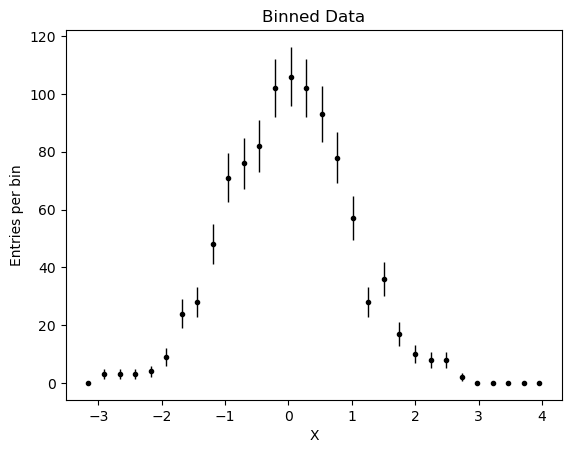

In [26]:
fit = fitlib.Fitter.binned(data,30)
fit.plot_data()
plt.title("Binned Data")
plt.xlabel("X")
plt.ylabel("Entries per bin")
plt.show()

---

## Step 4: Define a PDF
Define a Gaussian PDF and assign it to the fitter. Limits are not necessary for this fit, but are added for demonstration.

In [35]:
fit.pdf = [
    fitlib.Normal(
        n=(100, 500, 1500), # (lower limit, starting value, upper limit)
        mu=(-1, 1), # (lower limit, upper limit)
        sigma=(0.5, np.inf)
    )
]

---

## Step 5: Perform the Fit
Use the `chi2` method to perform a chi-squared minimization fit.

In [36]:
# returns the iminuit minimizer object
fit.chi2()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 21.57                      │              Nfcn = 99               │
│ EDM = 1.23e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │    978    │    31     │            │            │   100   │  1500   │       │
│ 1 │ x1   │   0.009   │   0.030   │            │            │   -1    │    1    │       │
│ 2 │ x2   │   0.924   │   0.023   │            │            │   0.5   │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬────────────────────────────┐
│    │       x0       x1       x2 │
├────┼────────────────────────────┤
│ x0 │      980   3.2e-3   9.8e-3 │
│ x1 │   3.2e-3 0.000902   0.1e-3 │
│ x2 │   9.8e-3   0.1e-3 0.000555 │
└────┴────────────────────────────┘

We may view the results in this table too, where names are taken from the pdf function

In [37]:
fit.summary()

Component 1
| Parameter   |        Value |      Error |
|-------------|--------------|------------|
| n           | 977.923      | 31.2864    |
| mu          |   0.00902066 |  0.0300268 |
| sigma       |   0.924143   |  0.0235465 |



---

## Step 6: Visualize the Fit
Overlay the fitted PDF on the binned data.

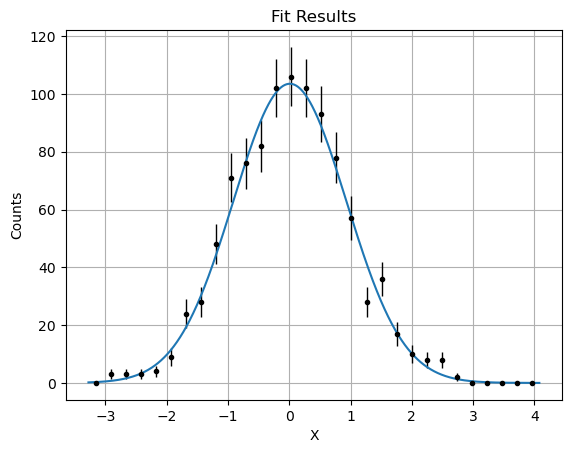

In [39]:
# Plot the fit alongside the data
fit.plot_data()
fit.plot_fit()
plt.title("Fit Results")
plt.xlabel("X")
plt.ylabel("Counts")
plt.grid(True)
plt.show()

## Example 2

This example will showcase more complex methods